In [1]:
"""!pip install pystac
!pip install pystac_client
!pip install planetary_computer
!pip install nb_black
!pip install odc-stac
!pip install geopandas
!pip install rioxarray
!pip install loguru
!pip install opencv-python
!pip install geopy
!pip install path
!pip install tqdm"""

'!pip install pystac\n!pip install pystac_client\n!pip install planetary_computer\n!pip install nb_black\n!pip install odc-stac\n!pip install geopandas\n!pip install rioxarray\n!pip install loguru\n!pip install opencv-python\n!pip install geopy\n!pip install path\n!pip install tqdm'

In [2]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [3]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

%matplotlib inline

In [4]:
DATA_DIR = Path.cwd().parent.resolve() / r"Documents\ticktickbloom"
assert DATA_DIR.exists()

# **metadata.csv**

In [5]:
metadata = pd.read_csv(DATA_DIR / "metadata.csv")
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [6]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23570 entries, 0 to 23569
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   uid        23570 non-null  object 
 1   latitude   23570 non-null  float64
 2   longitude  23570 non-null  float64
 3   date       23570 non-null  object 
 4   split      23570 non-null  object 
dtypes: float64(2), object(3)
memory usage: 920.8+ KB


# **train_labels.csv**

In [6]:
train_labels = pd.read_csv(DATA_DIR / "train_labels.csv")
train_labels.head()

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0


In [8]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17060 entries, 0 to 17059
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   uid       17060 non-null  object 
 1   region    17060 non-null  object 
 2   severity  17060 non-null  int64  
 3   density   17060 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 533.2+ KB


<AxesSubplot: >

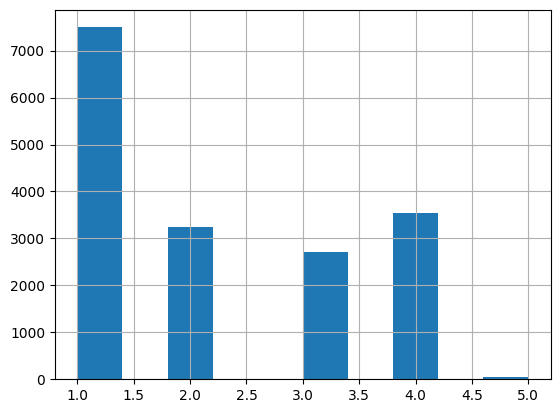

In [9]:
train_labels["severity"].hist()

In [10]:
train_labels["density"].describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4804\3295648470.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


<AxesSubplot: xlabel='density', ylabel='Density'>

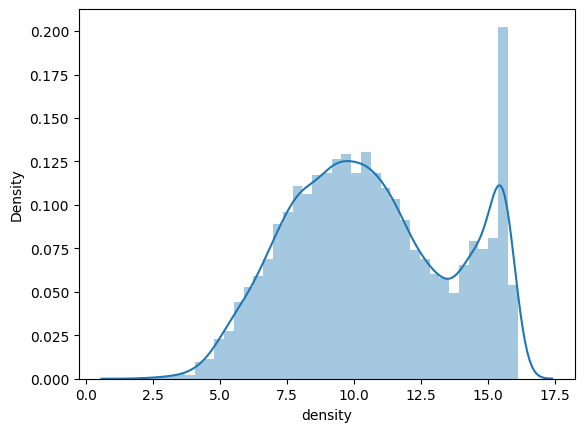

In [11]:
import seaborn as sns

sns.distplot(
    np.log(
        train_labels[(train_labels["density"] > 0) & (train_labels["density"] < 1e7)][
            "density"
        ]
    )
)

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4804\730536015.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_labels.corr(), annot=True, cmap="coolwarm", center=0)


<AxesSubplot: >

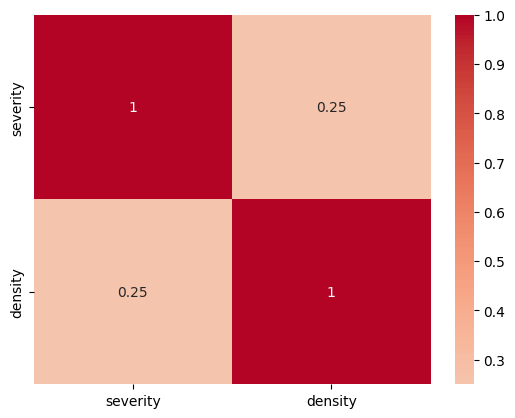

In [12]:
sns.heatmap(train_labels.corr(), annot=True, cmap="coolwarm", center=0)

DATA_merge

In [7]:
data = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)
data

,uid,region,severity,density,latitude,longitude,date,split
0,aabm,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train
1,aacd,south,1,290.0,35.875083,-78.878434,2020-11-19,train
2,aaee,south,1,1614.0,35.487000,-79.062133,2016-08-24,train
3,aaff,midwest,3,111825.0,38.049471,-99.827001,2019-07-23,train
4,aafl,midwest,4,2017313.0,39.474744,-86.898353,2021-08-23,train
...,...,...,...,...,...,...,...,...
17055,zzsv,south,3,113125.0,38.707825,-75.080867,2018-06-27,train
17056,zzuq,south,3,175726.0,35.794000,-79.015368,2015-08-06,train
17057,zzwo,midwest,2,48510.0,39.792190,-99.971050,2017-06-19,train
17058,zzwq,south,1,1271.0,35.794000,-79.012551,2015-03-24,train


C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4804\2638242000.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap="coolwarm", center=0)


<AxesSubplot: >

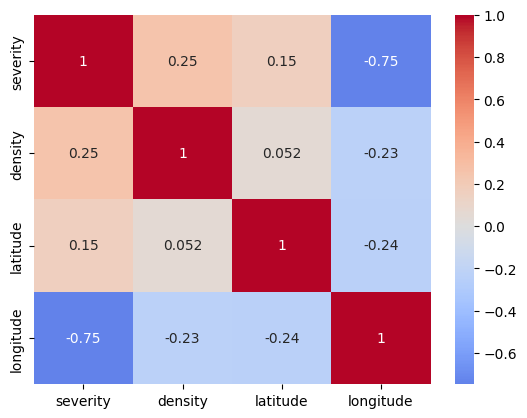

In [14]:
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", center=0)

<AxesSubplot: >

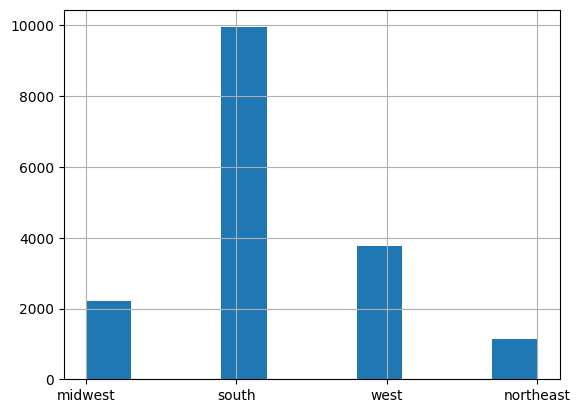

In [259]:
data["region"].hist()

<AxesSubplot: >

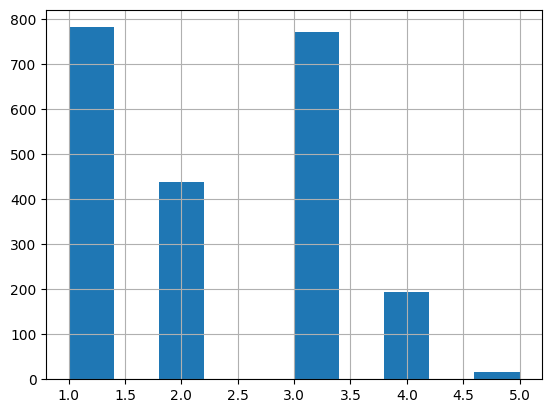

In [15]:
data[data["region"] == "midwest"]["severity"].hist()

<AxesSubplot: >

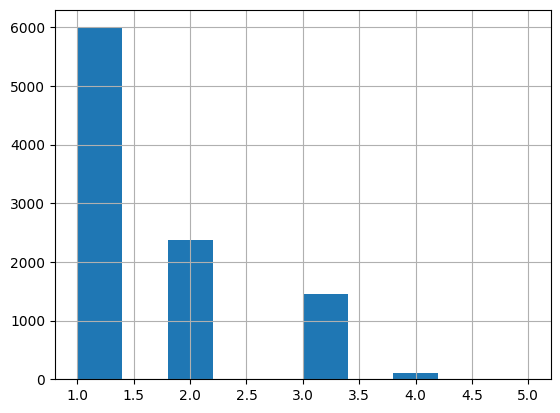

In [16]:
data[data["region"] == "south"]["severity"].hist()

<AxesSubplot: >

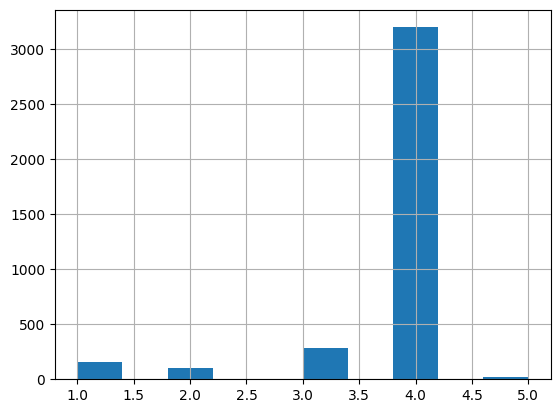

In [17]:
data[data["region"] == "west"]["severity"].hist()

<AxesSubplot: >

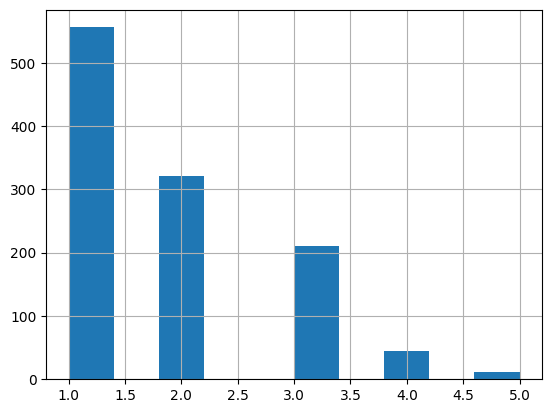

In [18]:
data[data["region"] == "northeast"]["severity"].hist()

# **Process feature data**

In [8]:
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

In [20]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [30]:
import geopy.distance as distance


# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]


# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%dT"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()


def crop_landsat_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = odc.stac.stac_load(
        [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    image_array = image[["red", "green", "blue"]].to_array().to_numpy()

    # normalize to 0 - 255 values
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    return image_array


# Refactor our process from above into functions
# Refactor our process from above into functions
def select_best_item(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
            }
            for item in items
        ]
    )

    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    # if we have sentinel-2, filter to sentinel-2 images only
    item_details["sentinel"] = item_details.platform.str.lower().str.contains(
        "sentinel"
    )
    if item_details["sentinel"].any():
        item_details = item_details[item_details["sentinel"] == True]

        # return the closest imagery by time
        listitems = item_details.sort_values(by="time_diff", ascending=True)

        for i in range(len(listitems)):
            cloud_coverage = listitems.iloc[i, 6].properties["eo:cloud_cover"]
            shadow_pixels = listitems.iloc[i, 6].properties[
                "s2:cloud_shadow_percentage"
            ]
            no_pixel_data = listitems.iloc[i, 6].properties[
                "s2:nodata_pixel_percentage"
            ]
            degraded_msi_data_percentage = listitems.iloc[i, 6].properties[
                "s2:degraded_msi_data_percentage"
            ]
            if (
                no_pixel_data < 10
                and cloud_coverage < 10
                and shadow_pixels < 10
                and degraded_msi_data_percentage < 10
            ):
                best_item = listitems.iloc[i]
    # if we have sentinel-2, filter to sentinel-2 images only
    else:
        item_details = item_details[item_details["landsat"] == True]
        listitems = item_details.sort_values(by="time_diff", ascending=True)
        for i in range(len(listitems)):
            # return the closest imagery by time
            cloud_coverage_land = listitems.iloc[i, 6].properties[
                "landsat:cloud_cover_land"
            ]
            cloud_coverage = listitems.iloc[i, 6].properties["eo:cloud_cover"]
            if cloud_coverage < 10 and cloud_coverage_land < 10:
                best_item = listitems.iloc[i]
    return (
        best_item["item_obj"],
        best_item["platform"],
        best_item["datetime"],
    )


def image_to_features(image_array):
    """
    Convert an image array of the form (color band, height, width) to a
    1-dimensional list of features. Returns a list where the first three
    values are the averages of each color band, and the second three
    values are the medians of each color band.
    """
    averages = image_array.mean(axis=(1, 2)).tolist()
    standard_dev = np.std(image_array, axis=(1, 2)).tolist()

    return averages + standard_dev

In [9]:
BENCHMARK_DATA_DIR = DATA_DIR.parents[0] / "ticktickbloom/benchmark"

# save image arrays in case we want to generate more features
IMAGE_ARRAY_DIR = BENCHMARK_DATA_DIR / "Train"
IMAGE_ARRAY_DIR.mkdir(exist_ok=True, parents=True)

In [10]:
IMAGE_ARRAY_DIR_TEST = BENCHMARK_DATA_DIR / "Test"
IMAGE_ARRAY_DIR_TEST.mkdir(exist_ok=True, parents=True)

In [11]:
# take a random subset of the training data for the benchmark
train_subset = metadata[metadata["split"] == "train"].sample(n=17060, random_state=2)
test_subset = metadata[metadata["split"] == "test"]
# combine train subset with all test data
metadata_subset = pd.concat([train_subset, metadata[metadata["split"] == "test"]])
metadata_subset.split.value_counts(dropna=False)

train    17060
test      6510
Name: split, dtype: int64

In [76]:
test_subset

,uid,latitude,longitude,date,split
1,aabn,36.559700,-121.510000,2016-08-31,test
12,aair,33.042600,-117.076000,2014-11-01,test
14,aajw,40.703968,-80.293050,2015-08-26,test
15,aalr,38.972500,-94.672930,2019-08-26,test
16,aalw,34.279000,-118.905000,2018-01-08,test
...,...,...,...,...,...
23556,zzpn,40.136410,-80.473740,2019-07-08,test
23560,zzrv,36.875400,-121.561000,2019-09-17,test
23563,zzsx,34.210000,-78.929389,2019-07-16,test
23565,zzvv,36.708500,-121.749000,2014-12-02,test


In [25]:
import rioxarray
import imageio
from IPython.display import Image
from PIL import Image as PILImage
from joblib import Parallel, delayed
import multiprocessing
import pandas as pd


def extract_images(row):
    pass
    # check if we've already saved the selected image array
    image_array_pth = IMAGE_ARRAY_DIR / f"{row.uid}.npy"

    if image_array_pth.exists():
        with open(image_array_pth, "rb") as f:
            image_array = np.load(f)

    # search and load the image array if not
    else:
        try:
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=50000
            )
            date_range = get_date_range(row.date, time_buffer_days=15)

            # search the planetary computer
            search = catalog.search(
                collections=["sentinel-2-l2a", "landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                pass
            else:
                best_item, item_platform, item_date = select_best_item(
                    items, row.date, row.latitude, row.longitude
                )
                # add to dictionary tracking best items
                selected_items[row.uid] = {
                    "item_object": best_item,
                    "item_platform": item_platform,
                    "item_date": item_date,
                }

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=3000
            )

            # crop the image
            if "sentinel" in item_platform.lower():
                image_array = crop_sentinel_image(best_item, feature_bbox)
            else:
                image_array = crop_landsat_image(best_item, feature_bbox)

            # save image array so we don't have to rerun
            image = np.transpose(image_array, axes=[1, 2, 0]).astype(np.uint8)
            # selected_items[row.uid] = {"image_array": image_array}
            imageio.imwrite(IMAGE_ARRAY_DIR / f"{row.uid}.png", image)

        # keep track of any that ran into errors without interrupting the process
        except:
            errored_ids.append(row.uid)
    return "ok"

Import train images

In [14]:
import rioxarray
import imageio
from IPython.display import Image
from PIL import Image as PILImage
from joblib import Parallel, delayed
import multiprocessing

# this cell takes a LONG time because it iterates over all data!

# save outputs in dictionaries
selected_items = {}
selected_images = {}
features_dict = {}
errored_ids = []
found_images = 0
bestitemselected = 0

for row in tqdm(train_subset.itertuples(), total=len(train_subset)):
    image_array_pth = IMAGE_ARRAY_DIR / f"{row.uid}.npy"

    if image_array_pth.exists():
        with open(image_array_pth, "rb") as f:
            image_array = np.load(f)

    # search and load the image array if not
    else:
        try:
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=50000
            )
            date_range = get_date_range(row.date, time_buffer_days=15)

            # search the planetary computer
            search = catalog.search(
                collections=["sentinel-2-l2a", "landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                pass
            else:
                best_item, item_platform, item_date = select_best_item(
                    items, row.date, row.latitude, row.longitude
                )
                # add to dictionary tracking best items
                selected_items[row.uid] = {
                    "item_object": best_item,
                    "item_platform": item_platform,
                    "item_date": item_date,
                }

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=3000
            )

            # crop the image
            if "sentinel" in item_platform.lower():
                image_array = crop_sentinel_image(best_item, feature_bbox)
            else:
                image_array = crop_landsat_image(best_item, feature_bbox)

            # save image array so we don't have to rerun
            image = np.transpose(image_array, axes=[1, 2, 0]).astype(np.uint8)
            # selected_items[row.uid] = {"image_array": image_array}
            imageio.imwrite(IMAGE_ARRAY_DIR / f"{row.uid}.png", image)

        # keep track of any that ran into errors without interrupting the process
        except:
            errored_ids.append(row.uid)

  0%|          | 23/17060 [00:20<5:55:45,  1.25s/it]

In [80]:
import rioxarray
import imageio
from IPython.display import Image
from PIL import Image as PILImage
from joblib import Parallel, delayed
import multiprocessing

# this cell takes a LONG time because it iterates over all data!

# save outputs in dictionaries
selected_items_test = {}
selected_images_test = {}
features_dict_test = {}
errored_ids_test = []
found_images_test = 0
bestitemselected_test = 0

for row in tqdm(test_subset.itertuples(), total=len(test_subset)):
    image_array_pth = IMAGE_ARRAY_DIR_TEST / f"{row.uid}.npy"  ##????????

    if image_array_pth.exists():
        with open(image_array_pth, "rb") as f:
            image_array = np.load(f)

    # search and load the image array if not
    else:
        try:
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=50000
            )
            date_range = get_date_range(row.date, time_buffer_days=15)

            # search the planetary computer
            search = catalog.search(
                collections=["sentinel-2-l2a", "landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                pass
            else:
                best_item, item_platform, item_date = select_best_item(
                    items, row.date, row.latitude, row.longitude
                )
                # add to dictionary tracking best items
                selected_items[row.uid] = {
                    "item_object": best_item,
                    "item_platform": item_platform,
                    "item_date": item_date,
                }

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=3000
            )

            # crop the image
            if "sentinel" in item_platform.lower():
                image_array = crop_sentinel_image(best_item, feature_bbox)
            else:
                image_array = crop_landsat_image(best_item, feature_bbox)

            # save image array so we don't have to rerun
            image = np.transpose(image_array, axes=[1, 2, 0]).astype(np.uint8)
            # selected_items[row.uid] = {"image_array": image_array}
            imageio.imwrite(IMAGE_ARRAY_DIR_TEST / f"{row.uid}.png", image)

        # keep track of any that ran into errors without interrupting the process
        except:
            errored_ids.append(row.uid)

100%|██████████| 6510/6510 [1:43:14<00:00,  1.05it/s]   


In [26]:
import os
import stat
from PIL import Image

paths = sorted(list(IMAGE_ARRAY_DIR.glob("*.png")))
path_list = os.path.split(paths[0])
id = path_list[1][:4]

im = Image.open(path_list[0] + "\\" + path_list[1])
np.asarray(im).shape

(605, 604, 3)

In [27]:
from keras_preprocessing.image import ImageDataGenerator
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
import os
import stat
from PIL import Image

c:\Users\Administrateur\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


creating features

In [28]:
paths = sorted(list(IMAGE_ARRAY_DIR.glob("*.png")))
path_list = os.path.split(paths[0])
id = path_list[1][:4]

im = Image.open(path_list[0] + "\\" + path_list[1])
np.asarray(im).shape

(605, 604, 3)

In [32]:
features_dict = {}
ids = []
import os
import stat
from PIL import Image

paths = sorted(list(IMAGE_ARRAY_DIR.glob("*.png")))
path_list = os.path.split(paths[0])
id = path_list[1][:4]

im = Image.open(path_list[0] + "\\" + path_list[1])
np.asarray(im).shape

for i in tqdm(range(len(paths))):
    path_list = os.path.split(paths[i])
    image_array = np.asarray(Image.open(path_list[0] + "\\" + path_list[1]))

    # convert image to 1-dimensional features
    image_features = image_to_features(image_array.T)
    features_dict[path_list[1][:4]] = [path_list[1][:4]] + image_features

100%|██████████| 6262/6262 [06:13<00:00, 16.75it/s]


In [33]:
features_dict["aabm"]

['aabm',
 41.80846423293744,
 68.91657818400745,
 40.65198128181271,
 37.0,
 70.0,
 38.0]

In [35]:
# bring features into a dataframe
image_features = pd.DataFrame(features_dict).T
image_features.columns = [
    "uid",
    "red_average",
    "green_average",
    "blue_average",
    "red_median",
    "green_median",
    "blue_median",
]
image_features.head()

,uid,red_average,green_average,blue_average,red_median,green_median,blue_median
aabm,aabm,41.808464,68.916578,40.651981,37.0,70.0,38.0
aacd,aacd,58.694434,58.83759,43.420349,39.0,42.0,26.0
aaee,aaee,37.174914,55.106826,27.210063,21.0,41.0,18.0
aaff,aaff,87.930222,94.751895,59.8973,77.0,89.0,53.0
aafl,aafl,43.458332,59.218384,46.278988,22.0,42.0,27.0


region feature is highly correlated with the classes ==> create a region column for test

In [31]:
image_features.iloc[0]

red_average      41.808464
green_average    68.916578
blue_average     40.651981
red_median       37.000000
green_median     70.000000
blue_median      38.000000
Name: aabm, dtype: float64

In [36]:
classifier_data = image_features.merge(
    data, how="left", left_on="uid", right_on="uid", validate="1:1"
)
classifier_data

,uid,red_average,green_average,blue_average,red_median,green_median,blue_median,region,severity,density,latitude,longitude,date,split
0,aabm,41.808464,68.916578,40.651981,37.0,70.0,38.0,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train
1,aacd,58.694434,58.83759,43.420349,39.0,42.0,26.0,south,1,290.0,35.875083,-78.878434,2020-11-19,train
2,aaee,37.174914,55.106826,27.210063,21.0,41.0,18.0,south,1,1614.0,35.487000,-79.062133,2016-08-24,train
3,aaff,87.930222,94.751895,59.8973,77.0,89.0,53.0,midwest,3,111825.0,38.049471,-99.827001,2019-07-23,train
4,aafl,43.458332,59.218384,46.278988,22.0,42.0,27.0,midwest,4,2017313.0,39.474744,-86.898353,2021-08-23,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6257,zzkp,143.65754,112.679125,81.072908,139.0,108.0,79.0,west,3,391600.0,42.238550,-111.853100,2017-07-18,train
6258,zzlt,38.648277,52.134057,32.834635,25.0,44.0,21.0,south,3,182856.0,35.836460,-78.976300,2016-05-24,train
6259,zzpz,30.824001,48.589496,29.571373,22.0,43.0,25.0,south,3,118603.0,35.726309,-79.125853,2019-07-17,train
6260,zzqy,86.799796,85.564742,59.468982,84.0,82.0,57.0,west,4,5548841.0,37.928600,-121.561000,2018-05-15,train


Stander deviation better than median 

In [ ]:
X=data.drop(columns=["date", "uid", "split","region",'severity'], inplace=False)
y=data['severity']


In [ ]:
image = odc.stac.stac_load(
        [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
image_array = image[["red", "green", "blue"]].to_array().to_numpy()

In [32]:
for row in tqdm(train_subset[12695:].itertuples(), total=len(train_subset[12695:])):
    ## QUERY STAC API
    # get query ranges for location and date
    search_bbox = get_bounding_box(row.latitude, row.longitude, meter_buffer=50000)
    date_range = get_date_range(row.date, time_buffer_days=15)

    # search the planetary computer
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=search_bbox,
        datetime=date_range,
    )
    items = [item for item in search.get_all_items()]

    ## GET BEST IMAGE
    if len(items) == 0:
        pass
    else:
        try:
            best_item, item_platform, item_date = select_best_item(
                items, row.date, row.latitude, row.longitude
            )
        except:
            pass
        # add to dictionary tracking best items
    feature_bbox = get_bounding_box(row.latitude, row.longitude, meter_buffer=3000)

    (minx, miny, maxx, maxy) = feature_bbox

    try:
        # spectral bands
        nir = (
            rioxarray.open_rasterio(pc.sign(best_item.assets["B08"].href)).rio.clip_box(
                minx=minx,
                miny=miny,
                maxx=maxx,
                maxy=maxy,
                crs="EPSG:4326",
            )
        ).to_numpy()
        red = (
            rioxarray.open_rasterio(pc.sign(best_item.assets["B04"].href)).rio.clip_box(
                minx=minx,
                miny=miny,
                maxx=maxx,
                maxy=maxy,
                crs="EPSG:4326",
            )
        ).to_numpy()
        green = (
            rioxarray.open_rasterio(pc.sign(best_item.assets["B03"].href)).rio.clip_box(
                minx=minx,
                miny=miny,
                maxx=maxx,
                maxy=maxy,
                crs="EPSG:4326",
            )
        ).to_numpy()
        blue = (
            rioxarray.open_rasterio(pc.sign(best_item.assets["B02"].href)).rio.clip_box(
                minx=minx,
                miny=miny,
                maxx=maxx,
                maxy=maxy,
                crs="EPSG:4326",
            )
        ).to_numpy()
        n_nir = (
            rioxarray.open_rasterio(pc.sign(best_item.assets["B8A"].href)).rio.clip_box(
                minx=minx,
                miny=miny,
                maxx=maxx,
                maxy=maxy,
                crs="EPSG:4326",
            )
        ).to_numpy()
        red_v = (
            rioxarray.open_rasterio(pc.sign(best_item.assets["B05"].href)).rio.clip_box(
                minx=minx,
                miny=miny,
                maxx=maxx,
                maxy=maxy,
                crs="EPSG:4326",
            )
        ).to_numpy()

        # different shapes
        red_v = red_v.astype(np.float32)
        red_v = transforms.Resize((605, 604))(
            transforms.ToPILImage()(red_v.transpose())
        )
        red_v = np.asarray(red_v)

        n_nir = n_nir.astype(np.float32)
        n_nir = transforms.Resize((605, 604))(
            transforms.ToPILImage()(n_nir.transpose())
        )
        n_nir = np.asarray(n_nir)

        red = red.astype(np.float32)
        red = transforms.Resize((605, 604))(transforms.ToPILImage()(red.transpose()))
        red = np.asarray(red)

        blue = blue.astype(np.float32)
        blue = transforms.Resize((605, 604))(transforms.ToPILImage()(blue.transpose()))
        blue = np.asarray(blue)

        green = green.astype(np.float32)
        green = transforms.Resize((605, 604))(
            transforms.ToPILImage()(green.transpose())
        )
        green = np.asarray(green)

        nir = n_nir.astype(np.float32)
        nir = transforms.Resize((605, 604))(transforms.ToPILImage()(nir.transpose()))
        nir = np.asarray(nir)

        # spectral indices
        NDVI = (nir - red) / (nir + red)
        NDCI = (red_v - red) / (red_v + red)
        B8AB4 = (n_nir - red) / (n_nir + red)
        B3B2 = (green - blue) / (green + blue)
        im = np.stack((NDVI, NDCI, B8AB4, B3B2), axis=-1)
        path = "Train_tensors/" + row.uid + ".npy"
        np.save(DATA_DIR / path, im.T)
    except:
        pass

  0%|          | 9/4365 [00:40<5:26:46,  4.50s/it]C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4804\3135180196.py:122: RuntimeWarning: invalid value encountered in divide
  B3B2 = (green - blue) / (green + blue)
  1%|          | 40/4365 [03:03<9:25:10,  7.84s/it] C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4804\3135180196.py:122: RuntimeWarning: invalid value encountered in divide
  B3B2 = (green - blue) / (green + blue)
  1%|          | 41/4365 [03:11<9:47:37,  8.15s/it]C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4804\3135180196.py:122: RuntimeWarning: invalid value encountered in divide
  B3B2 = (green - blue) / (green + blue)
  2%|▏         | 73/4365 [07:58<4:57:47,  4.16s/it] C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4804\3135180196.py:119: RuntimeWarning: invalid value encountered in divide
  NDVI = (nir - red) / (nir + red)
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4804\3135180196.py:120: RuntimeWarning: invalid value encountered in

In [33]:
for row in tqdm(test_subset.itertuples(), total=len(test_subset)):
    ## QUERY STAC API
    # get query ranges for location and date
    search_bbox = get_bounding_box(row.latitude, row.longitude, meter_buffer=50000)
    date_range = get_date_range(row.date, time_buffer_days=15)

    # search the planetary computer
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=search_bbox,
        datetime=date_range,
    )
    items = [item for item in search.get_all_items()]

    ## GET BEST IMAGE
    if len(items) == 0:
        pass
    else:
        try:
            best_item, item_platform, item_date = select_best_item(
                items, row.date, row.latitude, row.longitude
            )
        except:
            pass
        # add to dictionary tracking best items
    feature_bbox = get_bounding_box(row.latitude, row.longitude, meter_buffer=3000)

    (minx, miny, maxx, maxy) = feature_bbox

    try:
        # spectral bands
        nir = (
            rioxarray.open_rasterio(pc.sign(best_item.assets["B08"].href)).rio.clip_box(
                minx=minx,
                miny=miny,
                maxx=maxx,
                maxy=maxy,
                crs="EPSG:4326",
            )
        ).to_numpy()
        red = (
            rioxarray.open_rasterio(pc.sign(best_item.assets["B04"].href)).rio.clip_box(
                minx=minx,
                miny=miny,
                maxx=maxx,
                maxy=maxy,
                crs="EPSG:4326",
            )
        ).to_numpy()
        green = (
            rioxarray.open_rasterio(pc.sign(best_item.assets["B03"].href)).rio.clip_box(
                minx=minx,
                miny=miny,
                maxx=maxx,
                maxy=maxy,
                crs="EPSG:4326",
            )
        ).to_numpy()
        blue = (
            rioxarray.open_rasterio(pc.sign(best_item.assets["B02"].href)).rio.clip_box(
                minx=minx,
                miny=miny,
                maxx=maxx,
                maxy=maxy,
                crs="EPSG:4326",
            )
        ).to_numpy()
        n_nir = (
            rioxarray.open_rasterio(pc.sign(best_item.assets["B8A"].href)).rio.clip_box(
                minx=minx,
                miny=miny,
                maxx=maxx,
                maxy=maxy,
                crs="EPSG:4326",
            )
        ).to_numpy()
        red_v = (
            rioxarray.open_rasterio(pc.sign(best_item.assets["B05"].href)).rio.clip_box(
                minx=minx,
                miny=miny,
                maxx=maxx,
                maxy=maxy,
                crs="EPSG:4326",
            )
        ).to_numpy()

        # different shapes
        red_v = red_v.astype(np.float32)
        red_v = transforms.Resize((605, 604))(
            transforms.ToPILImage()(red_v.transpose())
        )
        red_v = np.asarray(red_v)

        n_nir = n_nir.astype(np.float32)
        n_nir = transforms.Resize((605, 604))(
            transforms.ToPILImage()(n_nir.transpose())
        )
        n_nir = np.asarray(n_nir)

        red = red.astype(np.float32)
        red = transforms.Resize((605, 604))(transforms.ToPILImage()(red.transpose()))
        red = np.asarray(red)

        blue = blue.astype(np.float32)
        blue = transforms.Resize((605, 604))(transforms.ToPILImage()(blue.transpose()))
        blue = np.asarray(blue)

        green = green.astype(np.float32)
        green = transforms.Resize((605, 604))(
            transforms.ToPILImage()(green.transpose())
        )
        green = np.asarray(green)

        nir = n_nir.astype(np.float32)
        nir = transforms.Resize((605, 604))(transforms.ToPILImage()(nir.transpose()))
        nir = np.asarray(nir)

        # spectral indices
        NDVI = (nir - red) / (nir + red)
        NDCI = (red_v - red) / (red_v + red)
        B8AB4 = (n_nir - red) / (n_nir + red)
        B3B2 = (green - blue) / (green + blue)
        im = np.stack((NDVI, NDCI, B8AB4, B3B2), axis=-1)
        path = "Test_tensors/" + row.uid + ".npy"
        np.save(DATA_DIR / path, im.T)
    except:
        pass

  0%|          | 16/6510 [00:51<6:42:59,  3.72s/it]C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4804\2313343742.py:119: RuntimeWarning: invalid value encountered in divide
  NDVI = (nir - red) / (nir + red)
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4804\2313343742.py:120: RuntimeWarning: invalid value encountered in divide
  NDCI = (red_v - red) / (red_v + red)
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4804\2313343742.py:121: RuntimeWarning: invalid value encountered in divide
  B8AB4 = (n_nir - red) / (n_nir + red)
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4804\2313343742.py:122: RuntimeWarning: invalid value encountered in divide
  B3B2 = (green - blue) / (green + blue)
  1%|          | 47/6510 [02:34<8:02:57,  4.48s/it] C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4804\2313343742.py:119: RuntimeWarning: invalid value encountered in divide
  NDVI = (nir - red) / (nir + red)
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_4804\2313

Dataloaders

In [54]:
import random

dir = DATA_DIR / "Train_tensors"
paths = sorted(list(dir.glob("*.npy")))
test_size = int(0.2 * len(paths))
val_paths = random.sample(paths, test_size)
train_paths = [x for x in paths if x not in val_paths]

In [75]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, paths):
        self.tensor_paths = paths

    def load_tensor(self, index: int):
        tensor_path = self.tensor_paths[index]
        return np.load(tensor_path)

    def __len__(self):
        return len(self.tensor_paths)

    def __getitem__(self, index):
        img = self.load_tensor(index)
        tensor_path = self.tensor_paths[index]
        path_list = os.path.split(tensor_path)
        id = path_list[1][:4]
        y = train_labels[train_labels.uid == id]["severity"]
        return img, np.asarray(y)

In [81]:
train_dataset = Dataset(train_paths[:80])
val_dataset = Dataset(val_paths[:20])

In [82]:
train_dataset[0][1]

array([1], dtype=int64)

In [83]:
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=32, num_workers=0, shuffle=True
)

test_dataloader = DataLoader(
    dataset=val_dataset, batch_size=32, num_workers=0, shuffle=True
)

Resnet50 doesn't work with 4 channels :: to adress thsi issue we can add a conv layer before resnet

Custumized model

In [84]:
import torch
import torch.nn as nn
import torchvision.models as models


class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()

        # Convolutional layer to reduce number of channels from 4 to 3
        self.conv = nn.Conv2d(
            in_channels=4, out_channels=3, kernel_size=3, stride=1, padding=1
        )

        # Load a pre-trained ResNet50 model
        self.resnet = models.resnet50(pretrained=False)

    def forward(self, x):
        # Pass the input through the convolutional layer
        x = self.conv(x)

        # replace the last fully-connected layer with our own classifier
        num_ftrs = self.resnet.fc.in_features
        num_classes = 5
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

        # Pass the output through the ResNet50 model
        x = self.resnet(x)

        return x

In [85]:
model = CustomModel()
summary(model, (4, 605, 604))

c:\Users\Administrateur\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrateur\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 47005696 bytes.

In [69]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
):
    model.train()

    train_loss = 0

    for batch, (image, label) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(image)

        loss = loss_fn(output, label)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()


def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
):
    model.eval()

    test_loss = 0
    with torch.no_grad():
        for i, (image, label) in enumerate(dataloader):
            output = model(image)
            loss = loss_fn(output, label)
            test_loss += loss.item()
    test_loss /= len(dataloader)
    return test_loss


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs,
):
    # Create empty results dictionary
    results = {"train_loss": [], "test_loss": []}

    for epoch in tqdm(range(epochs)):
        train_loss = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
        )

        test_loss = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f} | "
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    # Return the filled results at the end of the epochs
    return results

In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model_result = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=train_dataloader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=10,
)

  0%|          | 0/10 [00:02<?, ?it/s]


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 749617152 bytes.

Create Tabular data

In [166]:
features_dict = {}
ids = []
import os
import stat
from PIL import Image

dir = DATA_DIR / "Train_tensors"
paths = sorted(list(dir.glob("*.npy")))


for i in tqdm(range(len(paths))):
    path_list = os.path.split(paths[i])
    img = np.load(path_list[0] + "\\" + path_list[1])

    # convert image to 1-dimensional features
    image_features = image_to_features(img)
    features_dict[path_list[1][:4]] = [path_list[1][:4]] + image_features

100%|██████████| 8733/8733 [06:35<00:00, 22.07it/s]


In [167]:
# bring features into a dataframe
train_set = pd.DataFrame(features_dict).T
train_set.columns = [
    "uid",
    "NDVI_average",
    "NDCI_average",
    "B8AB4_average",
    "B3B2_average",
    "NDVI_std",
    "NDCI_std",
    "B8AB4_std",
    "B3B2_std",
]
train_set

,uid,NDVI_average,NDCI_average,B8AB4_average,B3B2_average,NDVI_std,NDCI_std,B8AB4_std,B3B2_std
aabm,aabm,0.343934,0.269086,0.346473,0.258279,0.563046,0.28364,0.530445,0.108864
aacd,aacd,0.577155,0.30272,0.584092,0.207783,0.283537,0.168081,0.244919,0.096324
aaee,aaee,0.806483,0.46766,0.809909,0.362584,0.155168,0.139384,0.139514,0.068382
aaff,aaff,0.589891,0.280622,0.589391,0.240772,0.176111,0.093332,0.159369,0.050765
aafl,aafl,0.712463,0.400284,0.709387,0.168127,0.301436,0.170557,0.312392,0.093035
...,...,...,...,...,...,...,...,...,...
zzlt,zzlt,0.641525,0.379613,0.592839,0.276733,0.302531,0.207885,0.408199,0.12857
zzpz,zzpz,0.837559,0.485531,0.831721,0.258866,0.123049,0.131115,0.146656,0.053166
zzqy,zzqy,0.443511,0.216089,0.438741,0.200383,0.394755,0.174112,0.313257,0.102793
zzrl,zzrl,0.834317,0.482572,0.83264,0.297682,0.115169,0.139171,0.121535,0.058119


In [170]:
dataframe = train_set.merge(
    train_labels, how="left", left_on="uid", right_on="uid", validate="1:1"
)

In [171]:
dataframe

,uid,NDVI_average,NDCI_average,B8AB4_average,B3B2_average,NDVI_std,NDCI_std,B8AB4_std,B3B2_std,region,severity,density
0,aabm,0.343934,0.269086,0.346473,0.258279,0.563046,0.28364,0.530445,0.108864,midwest,1,585.0
1,aacd,0.577155,0.30272,0.584092,0.207783,0.283537,0.168081,0.244919,0.096324,south,1,290.0
2,aaee,0.806483,0.46766,0.809909,0.362584,0.155168,0.139384,0.139514,0.068382,south,1,1614.0
3,aaff,0.589891,0.280622,0.589391,0.240772,0.176111,0.093332,0.159369,0.050765,midwest,3,111825.0
4,aafl,0.712463,0.400284,0.709387,0.168127,0.301436,0.170557,0.312392,0.093035,midwest,4,2017313.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8728,zzlt,0.641525,0.379613,0.592839,0.276733,0.302531,0.207885,0.408199,0.12857,south,3,182856.0
8729,zzpz,0.837559,0.485531,0.831721,0.258866,0.123049,0.131115,0.146656,0.053166,south,3,118603.0
8730,zzqy,0.443511,0.216089,0.438741,0.200383,0.394755,0.174112,0.313257,0.102793,west,4,5548841.0
8731,zzrl,0.834317,0.482572,0.83264,0.297682,0.115169,0.139171,0.121535,0.058119,south,1,4293.0


In [36]:
features_dict = {}
ids = []
import os
import stat
from PIL import Image

dir = DATA_DIR / "Test_tensors"
paths = sorted(list(dir.glob("*.npy")))


for i in tqdm(range(len(paths))):
    try:
        path_list = os.path.split(paths[i])
        img = np.load(path_list[0] + "\\" + path_list[1])

        # convert image to 1-dimensional features
        image_features = image_to_features(img)
        features_dict[path_list[1][:4]] = [path_list[1][:4]] + image_features 
    except:
        pass

100%|██████████| 2383/2383 [01:32<00:00, 25.86it/s] 


In [43]:
# bring features into a dataframe
image_features_test = pd.DataFrame(features_dict).T
image_features_test.columns = [
    "uid",
    "NDVI_average",
    "NDCI_average",
    "B8AB4_average",
    "B3B2_average",
    "NDVI_std",
    "NDCI_std",
    "B8AB4_std",
    "B3B2_std",
]
image_features_test.head()

,uid,NDVI_average,NDCI_average,B8AB4_average,B3B2_average,NDVI_std,NDCI_std,B8AB4_std,B3B2_std
aabn,aabn,0.420616,0.187061,0.407332,0.240617,0.284226,0.157285,0.260457,0.082642
aalw,aalw,0.345382,0.126671,0.350026,0.221295,0.224002,0.119462,0.183258,0.081307
aauy,aauy,0.5069,0.221767,0.515237,0.23206,0.18573,0.104632,0.142086,0.072153
aays,aays,0.295637,0.20213,0.315302,0.114495,0.502614,0.134937,0.388551,0.051683
abdc,abdc,0.517371,0.207837,0.515104,0.184397,0.189088,0.112363,0.198372,0.04782


Model

In [260]:
X = dataframe.drop(["density", "severity"], axis=1, inplace=False)
y = dataframe["severity"]

In [261]:
y

0       1
1       1
2       1
3       3
4       4
       ..
8728    3
8729    3
8730    4
8731    1
8732    1
Name: severity, Length: 8733, dtype: int64

In [262]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8733 entries, 0 to 8732
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   uid            8733 non-null   object
 1   NDVI_average   8495 non-null   object
 2   NDCI_average   8486 non-null   object
 3   B8AB4_average  8486 non-null   object
 4   B3B2_average   8139 non-null   object
 5   NDVI_std       8495 non-null   object
 6   NDCI_std       8486 non-null   object
 7   B8AB4_std      8486 non-null   object
 8   B3B2_std       8139 non-null   object
 9   region         8733 non-null   object
dtypes: object(10)
memory usage: 750.5+ KB


In [263]:
X.fillna(X.mean(), inplace=True)

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_7016\642802493.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  X.fillna(X.mean(), inplace=True)


In [264]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8733 entries, 0 to 8732
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   uid            8733 non-null   object 
 1   NDVI_average   8733 non-null   float64
 2   NDCI_average   8733 non-null   float64
 3   B8AB4_average  8733 non-null   float64
 4   B3B2_average   8733 non-null   float64
 5   NDVI_std       8733 non-null   float64
 6   NDCI_std       8733 non-null   float64
 7   B8AB4_std      8733 non-null   float64
 8   B3B2_std       8733 non-null   float64
 9   region         8733 non-null   object 
dtypes: float64(8), object(2)
memory usage: 750.5+ KB


In [265]:
dummy_reg = pd.get_dummies(X["region"])
df = pd.concat([X, dummy_reg], axis=1)
X = df.drop(["uid"], axis=1, inplace=False)
X

,NDVI_average,NDCI_average,B8AB4_average,B3B2_average,NDVI_std,NDCI_std,B8AB4_std,B3B2_std,region,midwest,northeast,south,west
0,0.343934,0.269086,0.346473,0.258279,0.563046,0.283640,0.530445,0.108864,midwest,1,0,0,0
1,0.577155,0.302720,0.584092,0.207783,0.283537,0.168081,0.244919,0.096324,south,0,0,1,0
2,0.806483,0.467660,0.809909,0.362584,0.155168,0.139384,0.139514,0.068382,south,0,0,1,0
3,0.589891,0.280622,0.589391,0.240772,0.176111,0.093332,0.159369,0.050765,midwest,1,0,0,0
4,0.712463,0.400284,0.709387,0.168127,0.301436,0.170557,0.312392,0.093035,midwest,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8728,0.641525,0.379613,0.592839,0.276733,0.302531,0.207885,0.408199,0.128570,south,0,0,1,0
8729,0.837559,0.485531,0.831721,0.258866,0.123049,0.131115,0.146656,0.053166,south,0,0,1,0
8730,0.443511,0.216089,0.438741,0.200383,0.394755,0.174112,0.313257,0.102793,west,0,0,0,1
8731,0.834317,0.482572,0.832640,0.297682,0.115169,0.139171,0.121535,0.058119,south,0,0,1,0


In [258]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_test_northeast = X[X["region"] == "northeast"]
X_test_midwest = X[X["region"] == "midwest"]
X_test_west = X[X["region"] == "west"]
X_test_south = X[X["region"] == "south"]

y_test_northeast = dataframe[dataframe["region"] == "northeast"]["severity"]
y_test_midwest = dataframe[dataframe["region"] == "midwest"]["severity"]
y_test_west = dataframe[dataframe["region"] == "west"]["severity"]
y_test_south = dataframe[dataframe["region"] == "south"]["severity"]

clf = DecisionTreeClassifier()
X_train1 = X_train.drop(["region"], axis=1, inplace=False)
clf.fit(X_train1, y_train)

X_test.drop("region", axis=1, inplace=True)
X_test_northeast.drop("region", axis=1, inplace=True)
X_test_midwest.drop("region", axis=1, inplace=True)
X_test_west.drop("region", axis=1, inplace=True)
X_test_south.drop("region", axis=1, inplace=True)

y_pred = clf.predict(X_test)
y_pred_northeast = clf.predict(X_test_northeast)
y_pred_midwest = clf.predict(X_test_midwest)
y_pred_west = clf.predict(X_test_west)
y_pred_south = clf.predict(X_test_south)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# avg_region_rmse
avg_reg_rmse = (
    1
    / 4
    * (
        np.sqrt(mean_squared_error(y_test_northeast, y_pred_northeast))
        + np.sqrt(mean_squared_error(y_test_midwest, y_pred_midwest))
        + np.sqrt(mean_squared_error(y_test_west, y_pred_west))
        + np.sqrt(mean_squared_error(y_test_south, y_pred_south))
    )
)
print("avg_region_rmse:", avg_reg_rmse)
print("rmse_norwest:", np.sqrt(mean_squared_error(y_test_northeast, y_pred_northeast)))
print("rmse_midwest:", np.sqrt(mean_squared_error(y_test_midwest, y_pred_midwest)))
print("rmse_south:", np.sqrt(mean_squared_error(y_test_south, y_pred_south)))
print("rmse_north:", np.sqrt(mean_squared_error(y_test_west, y_pred_west)))

Accuracy: 0.5563823697767601
RMSE: 0.984714312981783
avg_region_rmse: 0.4977482370458701
rmse_norwest: 0.5450043146345697
rmse_midwest: 0.5634025509061366
rmse_south: 0.5110780743815467
rmse_north: 0.37150800826122776


C:\Users\Administrateur\AppData\Local\Temp\ipykernel_7016\4220934123.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_northeast.drop("region", axis=1, inplace=True)
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_7016\4220934123.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_midwest.drop("region", axis=1, inplace=True)
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_7016\4220934123.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [266]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_test_northeast = X[X["region"] == "northeast"]
X_test_midwest = X[X["region"] == "midwest"]
X_test_west = X[X["region"] == "west"]
X_test_south = X[X["region"] == "south"]

y_test_northeast = dataframe[dataframe["region"] == "northeast"]["severity"]
y_test_midwest = dataframe[dataframe["region"] == "midwest"]["severity"]
y_test_west = dataframe[dataframe["region"] == "west"]["severity"]
y_test_south = dataframe[dataframe["region"] == "south"]["severity"]

clf = RandomForestClassifier()
X_train1 = X_train.drop(["region"], axis=1, inplace=False)
clf.fit(X_train1, y_train)

X_test.drop("region", axis=1, inplace=True)
X_test_northeast.drop("region", axis=1, inplace=True)
X_test_midwest.drop("region", axis=1, inplace=True)
X_test_west.drop("region", axis=1, inplace=True)
X_test_south.drop("region", axis=1, inplace=True)

y_pred = clf.predict(X_test)
y_pred_northeast = clf.predict(X_test_northeast)
y_pred_midwest = clf.predict(X_test_midwest)
y_pred_west = clf.predict(X_test_west)
y_pred_south = clf.predict(X_test_south)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# avg_region_rmse
avg_reg_rmse = (
    1
    / 4
    * (
        np.sqrt(mean_squared_error(y_test_northeast, y_pred_northeast))
        + np.sqrt(mean_squared_error(y_test_midwest, y_pred_midwest))
        + np.sqrt(mean_squared_error(y_test_west, y_pred_west))
        + np.sqrt(mean_squared_error(y_test_south, y_pred_south))
    )
)
print("avg_region_rmse:", avg_reg_rmse)
print("rmse_norwest:", np.sqrt(mean_squared_error(y_test_northeast, y_pred_northeast)))
print("rmse_midwest:", np.sqrt(mean_squared_error(y_test_midwest, y_pred_midwest)))
print("rmse_south:", np.sqrt(mean_squared_error(y_test_south, y_pred_south)))
print("rmse_north:", np.sqrt(mean_squared_error(y_test_west, y_pred_west)))

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_7016\867176185.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_northeast.drop("region", axis=1, inplace=True)
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_7016\867176185.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_midwest.drop("region", axis=1, inplace=True)
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_7016\867176185.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Accuracy: 0.6136233543216943
RMSE: 0.9135499738192434
avg_region_rmse: 0.4658084816914423
rmse_norwest: 0.5404435288915874
rmse_midwest: 0.5261650330502524
rmse_south: 0.49080055061348077
rmse_north: 0.3058248142104486
